In [1]:
### Local imports ###
import sys
sys.path.append('../') # define relative path for local imports
from src.models.scm import SCM
from src.datasets.dataset import SCMDataset


In [2]:
from refiners.training_utils.config import BaseConfig

class SCMConfig(BaseConfig):
    path_generated_images : str
    path_garment_images : str
    training : dict




config = SCMConfig.load_from_toml("/home/daniel/work/vton/configs/config_scm.toml")

/home/daniel/.pyenv/versions/3.10.13/envs/vton/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValidationError: 3 validation errors for SCMConfig
saving_path
  Extra inputs are not permitted [type=extra_forbidden, input_value='/home/daniel/work/vton/models', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/extra_forbidden
wandb
  Extra inputs are not permitted [type=extra_forbidden, input_value={'mode': 'online', 'entit...n', 'name': 'tonic_cup'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.6/v/extra_forbidden
scm
  Extra inputs are not permitted [type=extra_forbidden, input_value={'img_channel': 6, 'width...ec_blk_nums': [2, 2, 2]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.6/v/extra_forbidden

In [9]:
path_generated_images = "/var/hub/VITON-HD-warped"
path_garment_images = "/var/hub/VITON-HD/test"
mode = "val"

dataset = SCMDataset(path_generated_images, path_garment_images, mode)




In [10]:
dataset.update_image_files()

204it [00:03, 64.40it/s]


In [11]:
new_image_files = dataset.images_files

In [12]:
print(len(new_image_files))

199


In [13]:
path = path_generated_images + "/" + mode + "_files_v2.txt"
with open(path, "w") as f:
    for image in new_image_files:
        f.write(image + "\n")

In [3]:
# Display different images
import PIL  
import numpy as np
import matplotlib.pyplot as plt
from refiners.fluxion.utils import tensor_to_image

def display_image(image):
    image_to_display = tensor_to_image(image.unsqueeze(0))
    plt.imshow(image_to_display)
    plt.show()

10090_00.jpg


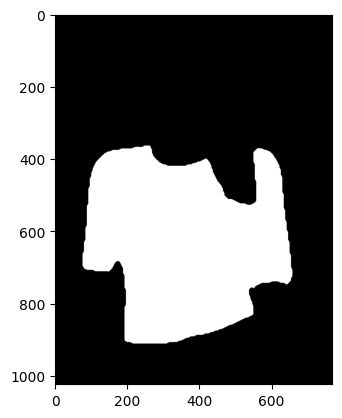

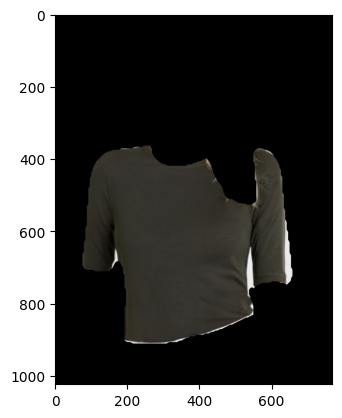

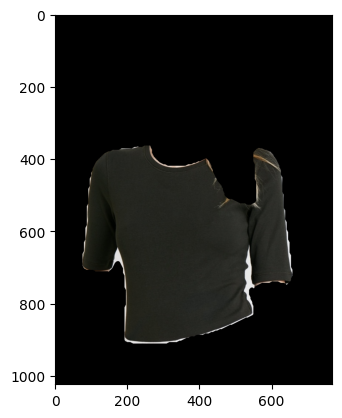

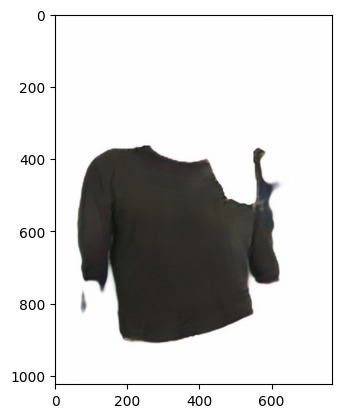

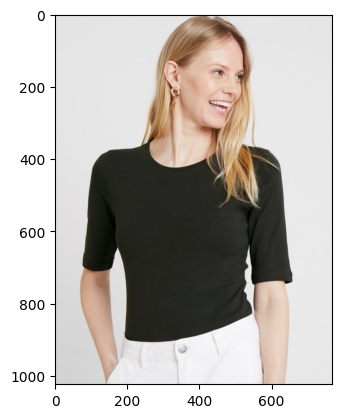

In [5]:
elemt = dataset[2]
print(elemt["file_name"])
for key in [
    "model_mask",
        "input_model_generate",
        "target",
        "input_warped_cloth",
        "model_real",
    ]:
    display_image(elemt[key])
    # Save image
    # image_to_save = tensor_to_image(elemt[key].unsqueeze(0))
    # file_name = elemt["file_name"] + "_" + key + ".png"
    # image_to_save.save(file_name)



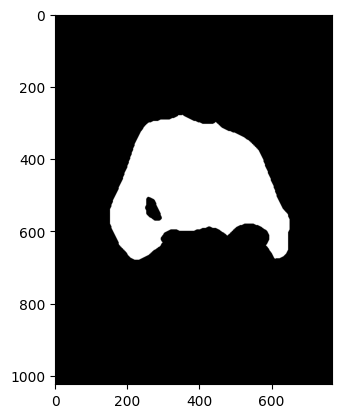

In [5]:
import torch

segmentation_image = elemt["parse_v3"]

def mask_orange_color(image: torch.Tensor, threshold: float = 0.5):
    # RGB of orange is (255, 165, 0)
    # Let's mask all the pixels around this color
    H,W = image.shape[1], image.shape[2]
    # Let's build tensor (3, H, W) with the RGB values of orange
    orange_tensor = torch.tensor([255, 165, 2]).unsqueeze(1).unsqueeze(2).repeat(1,H,W)/255
    white_tensor = torch.tensor([1, 1, 1]).unsqueeze(1).unsqueeze(2).repeat(1,H,W)
    # Let's compute the distance between the image and the orange color
    distance = torch.norm(image - orange_tensor, dim=0)
    # Let's build the mask
    mask = distance < threshold
    # image with only the orange pixels
    final_mask = white_tensor * mask
    
    return final_mask
    


masked_image = mask_orange_color(segmentation_image)
display_image(masked_image)


In [47]:
print(masked_image.sum()/masked_image.numel())

tensor(0.1319)


In [13]:
import torch

batch = elemt["input_scm"].unsqueeze(0)
with torch.no_grad():
    out = model(batch)
    print(out.shape)


    

torch.Size([1, 3, 1024, 768])


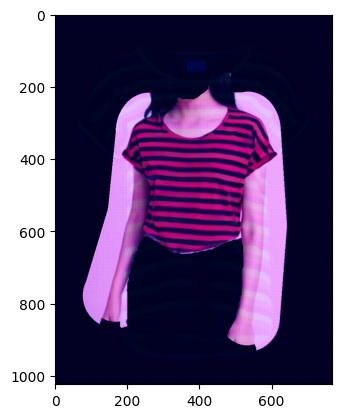

In [14]:
display_image(out[0])